#### Import Libraries

In [125]:
import pandas as pd
import numpy as np
from IPython.display import display
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path


### Read transformed data

In [126]:
df = pd.read_csv("atp_transformed/2000-2024 players_2.csv")

BASE_DIR = Path.cwd()

df.head()

C:\Users\Rusty\AppData\Local\Temp\ipykernel_14200\1629644042.py:1: DtypeWarning: Columns (18,41,42) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("atp_transformed/2000-2024 players_2.csv")


,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,score,best_of,tourney_round,...,median_diff_rolling_mean_10,total_diff_rolling_mean_10,mean_tb_numb_rolling_mean_10,median_tb_numb_rolling_mean_10,total_tb_numb_rolling_mean_10,mean_tb_diff_rolling_mean_10,median_tb_diff_rolling_mean_10,total_tb_diff_rolling_mean_10,elo_next_match,player_hand_missing
0,1975-237,Sao Paulo WCT,Carpet,32.0,A,1975-03-10,2,6-1 6-1,3,R32,...,3.200000,7.000000,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0
1,1975-2023,Fairfield,Carpet,32.0,A,1975-02-24,13,6-0 6-0,3,R32,...,4.700000,8.500000,NaN,NaN,0.0,NaN,NaN,0.0,NaN,0
2,1975-436,Charlotte,Clay,32.0,A,1975-04-21,7,6-4 3-6 6-4,3,R32,...,3.416667,5.857143,0.0,0.0,0.0,0.0,0.0,0.0,1571.881887,0
3,1974-2030,Merion,Grass,64.0,A,1974-08-25,247,6-2 6-2,3,R64,...,2.428571,5.428571,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0
4,1977-345,Monterrey WCT,Carpet,16.0,A,1977-02-28,4,6-0 6-1,3,R16,...,3.611111,7.200000,NaN,NaN,0.0,NaN,NaN,0.0,NaN,0


In [127]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1177422 entries, 0 to 1177421
Columns: 132 entries, tourney_id to player_hand_missing
dtypes: float64(96), int64(16), object(20)
memory usage: 1.2+ GB


In [128]:
df.columns

Index(['tourney_id', 'tourney_name', 'surface', 'draw_size', 'tourney_level',
       'tourney_date', 'match_num', 'score', 'best_of', 'tourney_round',
       ...
       'median_diff_rolling_mean_10', 'total_diff_rolling_mean_10',
       'mean_tb_numb_rolling_mean_10', 'median_tb_numb_rolling_mean_10',
       'total_tb_numb_rolling_mean_10', 'mean_tb_diff_rolling_mean_10',
       'median_tb_diff_rolling_mean_10', 'total_tb_diff_rolling_mean_10',
       'elo_next_match', 'player_hand_missing'],
      dtype='object', length=132)

#### Add Average Win Rate

In [129]:
df_copy = df.copy()

player_agg = (
    df.groupby('player_id')
      .agg(
          player_name=('player_name', 'first'),
          total_wins=('match_outcome', 'sum'),
          matches_played=('match_outcome', 'count')
      )
      .reset_index()
)

# Calculate average win rate
player_agg['average_win_rate'] = round(player_agg['total_wins'] / player_agg['matches_played'], 2)

# Merge average_win_rate back into the full dataframe copy
df_copy = df_copy.merge(player_agg[['player_id', 'average_win_rate']], on='player_id', how='left')

# Aggregated table for summaries
player_stats = player_agg[['player_id', 'player_name', 'total_wins', 'matches_played', 'average_win_rate']]

# Display the first few rows of the player_stats dataframe sorted by matches played
player_stats.sort_values(by='matches_played', ascending=False).head()

,player_id,player_name,total_wins,matches_played,average_win_rate
1656,103819,Roger Federer,1237,1492,0.83
2742,104925,Novak Djokovic,1183,1420,0.83
2566,104745,Rafael Nadal,1160,1410,0.82
1728,103893,Paolo Lorenzi,704,1309,0.54
1804,103970,David Ferrer,858,1298,0.66


#### Add Has Ever Beaten A Top 10 Ranked Opponent

In [130]:
# Build a time-aware binary flag 'has_ever_beaten_top_10'
# We find winner matches where the opponent's rank <= 10, then for each player
# compute a cumulative max ordered by match date so the flag is 1 from that match onward.

date_col = 'tourney_date'

# Prepare per-player match list (one row per player per match) to compute the cumulative flag
player_matches = df_copy[['player_id', 'player_tourney_match_id', date_col]].copy()

# create a match-level id used for ordering within a date
player_matches['tourney_match_id'] = player_matches['player_tourney_match_id'].str.split(':').str[1:].str.join(':')
player_matches = player_matches.reset_index().rename(columns={'index': 'row_order'})

# Identify winner rows and their opponent's rank by matching winners to losers within the same tourney match id
winners = df_copy[df_copy['match_outcome'] == 1][['player_tourney_match_id', 'player_id']].copy()
losers = df_copy[df_copy['match_outcome'] == 0][['player_tourney_match_id', 'player_rank']].copy()

# derive tourney_match_id on both sides so we can join winners to the opponents in the same match
winners['tourney_match_id'] = winners['player_tourney_match_id'].str.split(':').str[1:].str.join(':')
losers['tourney_match_id'] = losers['player_tourney_match_id'].str.split(':').str[1:].str.join(':')
losers = losers.rename(columns={'player_rank': 'opponent_rank'})

winner_vs_loser = pd.merge(
    winners[['player_id', 'tourney_match_id']],
    losers[['tourney_match_id', 'opponent_rank']],
    on='tourney_match_id',
    how='inner'
)

# Mark events where the winner beat a top-10 opponent
winner_vs_loser['beat_top10_event'] = (winner_vs_loser['opponent_rank'] <= 10).astype(int)

# Merge the event flag into the per-player-per-match timeline (only winners will have non-zero events)
# Merge on player_id + tourney_match_id. Because player_matches includes the original row_order,
# we'll sort by (player_id, tourney_date, row_order) so the winning event occurs before any other rows on the same date
player_matches = player_matches.merge(
    winner_vs_loser[['player_id', 'tourney_match_id', 'beat_top10_event']],
    left_on=['player_id', 'tourney_match_id'],
    right_on=['player_id', 'tourney_match_id'],
    how='left',
)
player_matches['beat_top10_event'] = player_matches['beat_top10_event'].fillna(0).astype(int)


player_matches = player_matches.sort_values(['player_id', date_col, 'row_order', 'tourney_match_id'])
player_matches['has_ever_beaten_top_10'] = player_matches.groupby('player_id')['beat_top10_event'].cummax().astype(int)

# Merge the result back into df_copy on player_id + player_tourney_match_id so every row (win or loss) gets the correct flag
df_copy = df_copy.merge(
    player_matches[['player_id', 'player_tourney_match_id', 'has_ever_beaten_top_10']],
    on=['player_id', 'player_tourney_match_id'],
    how='left'
)
df_copy['has_ever_beaten_top_10'] = df_copy['has_ever_beaten_top_10'].fillna(0).astype(int)

In [131]:
# Show all matches for a single player (Novak Djokovic) to see the flag flip to 1
player_name_example = 'Novak Djokovic'
player_rows = df_copy[df_copy['player_name'].str.contains(player_name_example, case=False, na=False)].copy()
cols = ['tourney_date', 'player_tourney_match_id', 'player_name', 'match_outcome', 'player_rank', 'has_ever_beaten_top_10']

# display all matches
display(player_rows[cols].reset_index(drop=True))

# Show the first match where the flag becomes 1
first_flip = player_rows[player_rows['has_ever_beaten_top_10'] == 1].head(1)
if not first_flip.empty:
    print('\nFirst match where has_ever_beaten_top_10==1:')
    display(first_flip[cols])
else:
    print('\nNo top-10 beating event found for this player in the dataset.')

,tourney_date,player_tourney_match_id,player_name,match_outcome,player_rank,has_ever_beaten_top_10
0,2003-07-14,104925:2003-M-FU-SCG-04A-2003:12,Novak Djokovic,1,768.0,0
1,2003-07-14,104925:2003-M-FU-SCG-04A-2003:22,Novak Djokovic,1,768.0,0
2,2003-07-14,104925:2003-M-FU-SCG-04A-2003:27,Novak Djokovic,1,768.0,0
3,2003-07-14,104925:2003-M-FU-SCG-04A-2003:30,Novak Djokovic,0,768.0,0
4,2003-07-21,104925:2003-M-FU-SCG-05A-2003:2,Novak Djokovic,0,774.0,0
...,...,...,...,...,...,...
1415,2024-10-02,104925:2024-5014:343,Novak Djokovic,1,4.0,1
1416,2024-10-02,104925:2024-5014:357,Novak Djokovic,1,4.0,1
1417,2024-10-02,104925:2024-5014:364,Novak Djokovic,1,4.0,1
1418,2024-10-02,104925:2024-5014:367,Novak Djokovic,1,4.0,1



First match where has_ever_beaten_top_10==1:


,tourney_date,player_tourney_match_id,player_name,match_outcome,player_rank,has_ever_beaten_top_10
488402,2005-10-31,104925:2005-352:21,Novak Djokovic,1,85.0,1


#### Add Upset Win

In [132]:
# Prepare winners and losers to get opponent ranks for winner rows
winners = df_copy[df_copy['match_outcome'] == 1][['player_tourney_match_id', 'tourney_match_id', 'player_id', 'player_rank']].copy()
losers = df_copy[df_copy['match_outcome'] == 0][['tourney_match_id', 'player_rank']].copy().rename(columns={'player_rank': 'opponent_rank'})

# Merge winners with their opponent rank (one row per winner)
winner_vs_loser = pd.merge(
    winners,
    losers[['tourney_match_id', 'opponent_rank']],
    on='tourney_match_id',
    how='left'
)

# An 'upset' is when the winning player's rank is at least 20 places worse (numerically higher) than the opponent's rank.
rank_diff = winner_vs_loser['player_rank'] - winner_vs_loser['opponent_rank']
winner_vs_loser['upset_win'] = (rank_diff >= 20).astype(int)

# Merge the upset flag back into the main dataframe; non-winner rows will get 0
df_copy = df_copy.merge(
    winner_vs_loser[['player_id', 'player_tourney_match_id', 'upset_win']],
    on=['player_id', 'player_tourney_match_id'],
    how='left'
)
df_copy['upset_win'] = df_copy['upset_win'].fillna(0).astype(int)


In [133]:
# Display upset matches: show both winner and loser rows for matches flagged as upset_win
# We select matches where the winning row has upset_win==1, then pull both rows for those tourney_match_id values.
upset_winners = df_copy[(df_copy['match_outcome'] == 1) & (df_copy['upset_win'] == 1)].copy()
num_upset_winner_rows = len(upset_winners)
num_upset_matches = upset_winners['tourney_match_id'].nunique()
print(f'Found {num_upset_winner_rows} upset winner rows across {num_upset_matches} matches.')

# Get the tourney_match_id values for upset matches and pull all rows (winners + losers) for those matches
upset_ids = upset_winners['tourney_match_id'].unique()
upset_matches = df_copy[df_copy['tourney_match_id'].isin(upset_ids)].copy()

# Sort so the winner appears before the loser (match_outcome: winner==1) and by date
upset_matches = upset_matches.sort_values(['tourney_date', 'tourney_match_id', 'match_outcome'], ascending=[True, True, False])

# Columns to display
cols = ['tourney_date', 'player_name', 'player_rank', 'player_tourney_match_id', 'upset_win']

# Typically there are two rows per match (winner + loser). Group and take the first 2 rows per match to ensure we show pairs
upset_pairs = upset_matches.groupby('tourney_match_id').head(2)[cols].reset_index(drop=True)

# Display a small sample and the full count
display(upset_pairs.head(10))

Found 169603 upset winner rows across 169603 matches.


,tourney_date,player_name,player_rank,player_tourney_match_id,upset_win
0,1975-02-03,John Holladay,253.0,202513:1975-660:21,1
1,1975-02-03,Jeff Austin,118.0,100245:1975-660:21,0
2,1975-02-03,John Holladay,253.0,202513:1975-660:9,1
3,1975-02-03,Mike Machette,214.0,100226:1975-660:9,0
4,1975-03-11,Chris Kachel,243.0,100382:1975-657:4,1
5,1975-03-11,John Holladay,182.0,202513:1975-657:4,0
6,1978-07-02,John Holladay,272.0,202513:1978-673:281,1
7,1978-07-02,Christophe Freyss,141.0,100443:1978-673:281,0
8,1978-07-02,Pascal Portes,352.0,100600:1978-673:288,1
9,1978-07-02,John Holladay,272.0,202513:1978-673:288,0


#### Played in Grand Slam Tourney

In [134]:
# Build a per-player timeline and mark GS events
player_matches = df_copy[['player_id', 'player_tourney_match_id', 'tourney_date', 'tourney_level']].copy()
player_matches['is_grand_slam_event'] = (player_matches['tourney_level'] == 'G').astype(int)

# Sort by player and date (tie-breaker: match id) and compute cumulative max so flag flips to 1 at first GS
player_matches = player_matches.sort_values(['player_id', 'tourney_date', 'player_tourney_match_id'])
player_matches['played_in_grand_slam'] = player_matches.groupby('player_id')['is_grand_slam_event'].cummax().astype(int)

# Merge back into df_copy so every row gets the flag
df_copy = df_copy.merge(
    player_matches[['player_id', 'player_tourney_match_id', 'played_in_grand_slam']],
    on=['player_id', 'player_tourney_match_id'],
    how='left'
)
df_copy['played_in_grand_slam'] = df_copy['played_in_grand_slam'].fillna(0).astype(int)

In [135]:
num_players_with_gs = df_copy.groupby('player_id')['played_in_grand_slam'].max().sum()
print(f'Total players who have played in at least one Grand Slam: {int(num_players_with_gs)}')

# Example: show first 10 rows for Novak Djokovic to verify the flag flips at the first GS match (if present)
player_name_example = 'Novak Djokovic'
sample_rows = df_copy[df_copy['player_name'].str.contains(player_name_example, case=False, na=False)].sort_values('tourney_date')
display(sample_rows[['tourney_date', 'player_tourney_match_id', 'tourney_level', 'player_name', 'played_in_grand_slam']].head(100))

Total players who have played in at least one Grand Slam: 1586


,tourney_date,player_tourney_match_id,tourney_level,player_name,played_in_grand_slam
488555,2003-07-14,104925:2003-M-FU-SCG-04A-2003:12,S,Novak Djokovic,0
488556,2003-07-14,104925:2003-M-FU-SCG-04A-2003:22,S,Novak Djokovic,0
488557,2003-07-14,104925:2003-M-FU-SCG-04A-2003:27,S,Novak Djokovic,0
488558,2003-07-14,104925:2003-M-FU-SCG-04A-2003:30,S,Novak Djokovic,0
488559,2003-07-21,104925:2003-M-FU-SCG-05A-2003:2,S,Novak Djokovic,0
...,...,...,...,...,...
488650,2005-08-29,104925:2005-560:103,G,Novak Djokovic,1
488651,2005-10-24,104925:2005-375:15,A,Novak Djokovic,1
488652,2005-10-24,104925:2005-375:24,A,Novak Djokovic,1
488655,2005-10-31,104925:2005-352:35,M,Novak Djokovic,1


#### Add Won Masters Tourney

In [136]:
# Build a cumulative 'won_masters_tourney' flag (Masters = tourney_level == 'M', final = tourney_round == 'F')
# Do NOT convert dates or modify df_copy values other than adding the final flag column.

# Prepare a temporary per-player timeline (keep original ordering via reset_index -> row_order)
player_matches = df_copy[[
    'player_id', 'player_tourney_match_id',
    'tourney_level', 'tourney_round', 'match_outcome', 'tourney_date'
]].copy()

# Preserve original row order for deterministic tie-breaking when multiple matches share the same tourney_date
player_matches = player_matches.reset_index().rename(columns={'index': 'row_order'})

# Event: winner of a Masters final
player_matches['won_masters_event'] = (
    (player_matches['tourney_level'] == 'M') &
    (player_matches['tourney_round'] == 'F') &
    (player_matches['match_outcome'] == 1)
).astype(int)

# Sort by player, date, then row_order so an actual win on a given date appears before other rows on the same date
player_matches = player_matches.sort_values(['player_id', 'tourney_date', 'row_order', 'player_tourney_match_id'])

# Cumulative flag: becomes 1 at the player's first Masters-final win and remains 1 afterwards.
player_matches['won_masters_tourney'] = player_matches.groupby('player_id')['won_masters_event'].cummax().astype(int)

# Merge the computed flag back into df_copy (adds only the new column; existing values are preserved)
df_copy = df_copy.merge(
    player_matches[['player_id', 'player_tourney_match_id', 'won_masters_tourney']],
    on=['player_id', 'player_tourney_match_id'],
    how='left'
)

# Fill missing with 0 and ensure integer type
df_copy['won_masters_tourney'] = df_copy['won_masters_tourney'].fillna(0).astype(int)

In [137]:
player_name_example = 'Novak Djokovic'

# Select player's rows, keep original df_copy index as a tie-breaker for ordering
djokovic = df_copy[df_copy['player_name'].str.contains(player_name_example, case=False, na=False)].copy()
djokovic = djokovic.reset_index().rename(columns={'index': 'row_order'})

# Columns to display
cols = [
    'tourney_date',
    'tourney_level',
    'tourney_round',
    'player_name',
    'match_outcome',
    'won_masters_tourney',
    'player_tourney_match_id'
]

# Display the timeline (show more rows if needed)
display(djokovic[cols].reset_index(drop=True).head(200))

# Print the first match where won_masters_tourney == 1 (if any)
first_flip = djokovic[djokovic['won_masters_tourney'] == 1].head(1)
if not first_flip.empty:
    print("\nFirst match where won_masters_tourney == 1:")
    display(first_flip[cols])
else:
    print("\nNo masters-final win found for this player in the dataset (won_masters_tourney never becomes 1).")

,tourney_date,tourney_level,tourney_round,player_name,match_outcome,won_masters_tourney,player_tourney_match_id
0,2003-07-14,S,R32,Novak Djokovic,1,0,104925:2003-M-FU-SCG-04A-2003:12
1,2003-07-14,S,R16,Novak Djokovic,1,0,104925:2003-M-FU-SCG-04A-2003:22
2,2003-07-14,S,QF,Novak Djokovic,1,0,104925:2003-M-FU-SCG-04A-2003:27
3,2003-07-14,S,SF,Novak Djokovic,0,0,104925:2003-M-FU-SCG-04A-2003:30
4,2003-07-21,S,R32,Novak Djokovic,0,0,104925:2003-M-FU-SCG-05A-2003:2
...,...,...,...,...,...,...,...
195,2007-04-29,A,F,Novak Djokovic,1,1,104925:2007-468:31
196,2007-05-07,M,R32,Novak Djokovic,1,1,104925:2007-416:37
197,2007-05-07,M,R16,Novak Djokovic,1,1,104925:2007-416:47
198,2007-05-07,M,QF,Novak Djokovic,0,1,104925:2007-416:52



First match where won_masters_tourney == 1:


,tourney_date,tourney_level,tourney_round,player_name,match_outcome,won_masters_tourney,player_tourney_match_id
187,2007-03-19,M,F,Novak Djokovic,1,1,104925:2007-403:95


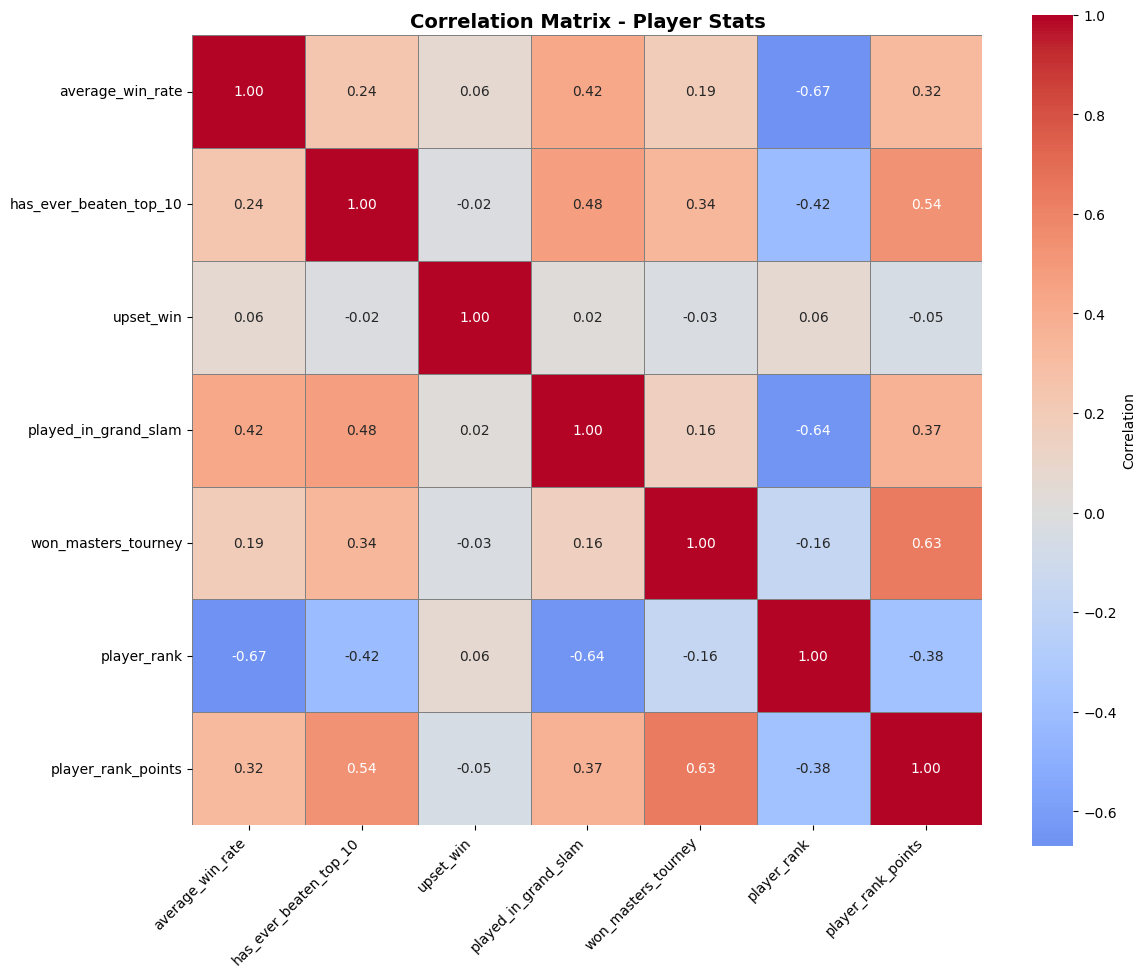

In [138]:
# Correlation matrix of numeric columns in player_stats
cols = ['average_win_rate', 'has_ever_beaten_top_10','upset_win', 'played_in_grand_slam',"won_masters_tourney", 'player_rank', 'player_rank_points']
corr_matrix = df_copy[cols].corr(numeric_only=True)

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, square=True, 
            fmt='.2f', cbar_kws={'label': 'Correlation'}, linewidths=0.5, linecolor='gray')
plt.title('Correlation Matrix - Player Stats', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

#### Export to CSV

In [139]:
df_copy.to_csv(BASE_DIR / "atp_transformed" / f"2000-2024 with achievements.csv", index=False)